# Data integration and batch correction

An important task of single-cell analysis is the integration of several samples, which we can perform with omicverse. 

Here we demonstrate how to merge data using omicverse and perform a corrective analysis for batch effects. We provide a total of 4 methods for batch effect correction in omicverse, including harmony, scanorama and combat which do not require GPU, and SIMBA which requires GPU. if available, we recommend using GPU-based scVI and scANVI to get the best batch effect correction results.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omicverse as ov
#print(f"omicverse version: {ov.__version__}")
import scanpy as sc
#print(f"scanpy version: {sc.__version__}")
ov.plot_set(font_path='Arial')
!date

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 05日 星期二 13:22:09 CST


## Data integration

First, we need to concat the data of scRNA-seq from different batch. We can use `sc.concat` to perform it。

The dataset we will use to demonstrate data integration contains several samples of bone marrow mononuclear cells. These samples were originally created for the Open Problems in Single-Cell Analysis NeurIPS Competition 2021.

We selected sample of `s1d3`, `s2d1` and `s3d7` to perform integrate. The individual data can be downloaded from figshare.

- s1d3:
- s2d1:
- s3d7:

In [3]:
adata1=ov.read('data/neurips2021_s1d3.h5ad')
adata1.obs['batch']='s1d3'
adata2=ov.read('data/neurips2021_s2d1.h5ad')
adata2.obs['batch']='s2d1'
adata3=ov.read('data/neurips2021_s3d7.h5ad')
adata3.obs['batch']='s3d7'

In [4]:
adata=sc.concat([adata1,adata2,adata3],merge='same')
adata

AnnData object with n_obs × n_vars = 27423 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

We can see that there are now three elements in the batch

In [5]:
adata.obs['batch'].unique()

array(['s1d3', 's2d1', 's3d7'], dtype=object)

In [6]:
import numpy as np
adata.X=adata.X.astype(np.int64)

## Data preprocess and Batch visualize

We first performed quality control of the data and normalisation with screening for highly variable genes. Then visualise potential batch effects in the data.

Here, we can set `batch_key=batch` to correct the doublet detectation and Highly variable genes identifcation.

In [7]:
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250},
              batch_key='batch')
adata

🖥️ Using CPU mode for QC...

📊 Step 1: Calculating QC Metrics
   Mitochondrial genes (prefix 'MT-'): 13 found
   ✓ QC metrics calculated:
     • Mean nUMIs: 19926 (range: 999-694009)
     • Mean genes: 1339 (range: 103-5543)
     • Mean mitochondrial %: 8.0% (max: 33.1%)
   📈 Original cell count: 27,423

🔧 Step 2: Quality Filtering (SEURAT)
   Thresholds: mito≤0.2, nUMIs≥500, genes≥250
   📊 Seurat Filter Results:
     • nUMIs filter (≥500): 0 cells failed (0.0%)
     • Genes filter (≥250): 420 cells failed (1.5%)
     • Mitochondrial filter (≤0.2): 285 cells failed (1.0%)
   ✓ Filters applied successfully
   ✓ Combined QC filters: 705 cells removed (2.6%)

🎯 Step 3: Final Filtering
   Parameters: min_genes=200, min_cells=3
   Ratios: max_genes_ratio=1, max_cells_ratio=1
   ✓ Final filtering: 0 cells, 0 genes removed

🔍 Step 4: Doublet Detection
   ⚠️  Note: 'scrublet' detection is too old and may not work properly
   💡 Consider using 'doublets_method=sccomposite' for better results
   

AnnData object with n_obs × n_vars = 26713 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

We can store the raw counts if we need the raw counts after filtered the HVGs.

In [8]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',
                       n_HVGs=3000,batch_key=None)
adata

Begin robust gene identification
After filtration, 13953/13953 genes are kept.     Among 13953 genes, 13953 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell
The following highly-expressed genes are not considered during normalization factor computation:
['IGKC', 'HBB', 'MALAT1', 'IGHA1', 'IGHM', 'HBA2', 'IGLC1', 'IGLC2', 'IGLC3']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 4.806804895401001 seconds.
End of size normalization: shiftlog and HVGs selection pearson


AnnData object with n_obs × n_vars = 26713 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [9]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

View of AnnData object with n_obs × n_vars = 26713 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

We can save the pre-processed data.

In [10]:
adata.write_h5ad('neurips2021_batch_normlog.h5ad',compression='gzip')

Similarly, we calculated PCA for HVGs and visualised potential batch effects in the data using pymde. pymde is GPU-accelerated UMAP.

In [11]:
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)

adata.obsm["X_mde_pca"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])

computing PCA
    with n_comps=50
    finished (0:00:10)


There is a very clear batch effect in the data

[<Axes: title={'center': 'batch'}, xlabel='X_mde_pca1', ylabel='X_mde_pca2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_pca1', ylabel='X_mde_pca2'>]

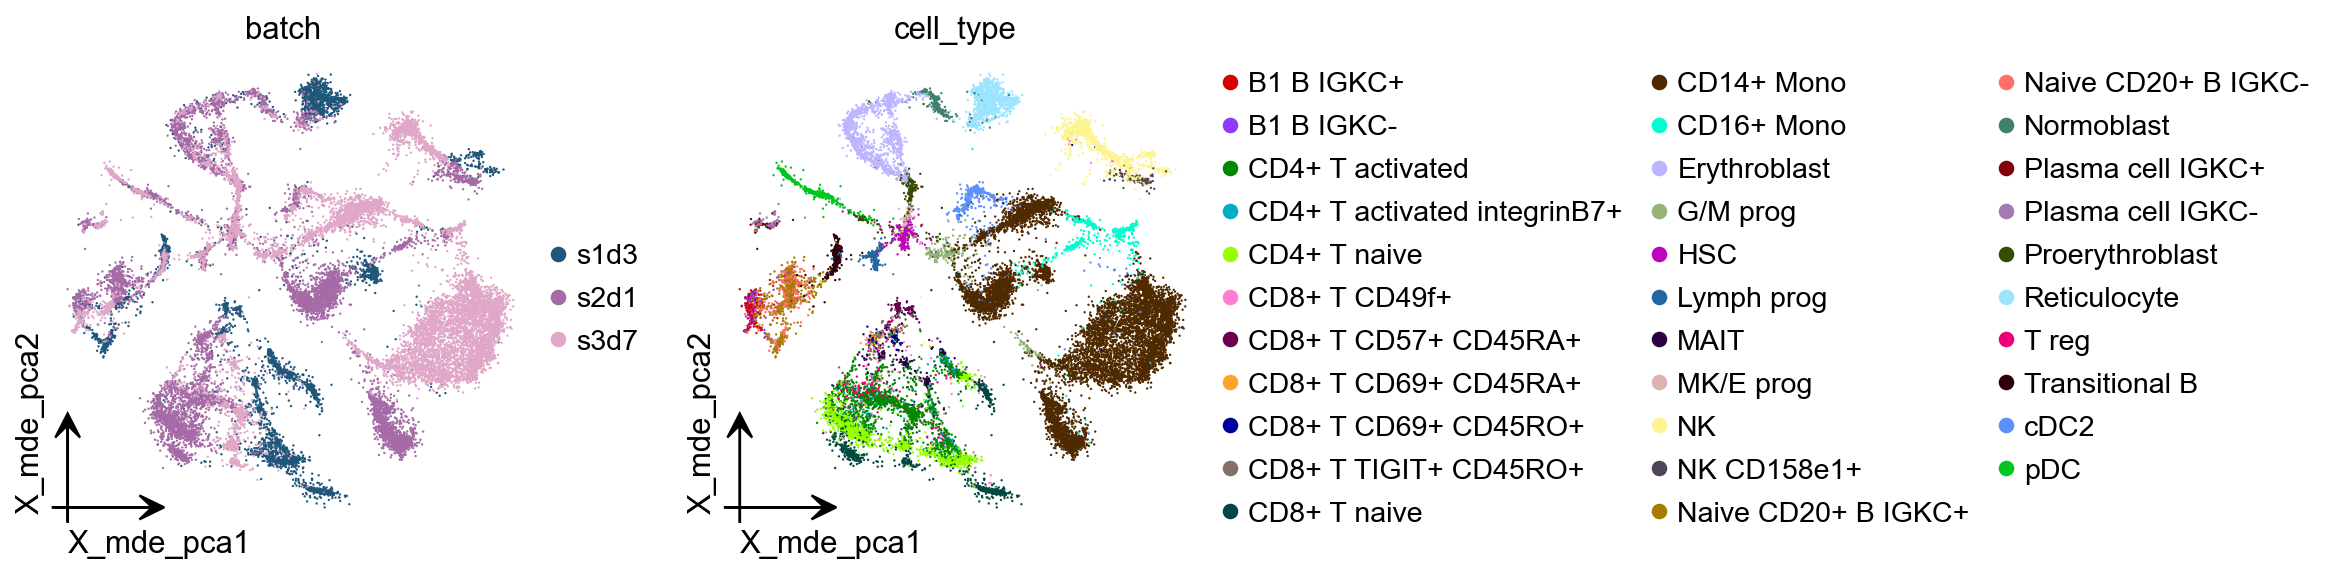

In [12]:
ov.utils.embedding(adata,
                basis='X_mde_pca',frameon='small',
                color=['batch','cell_type'],show=False)

## Harmony

Harmony is an algorithm for performing integration of single cell genomics datasets. Please check out manuscript on [Nature Methods](https://www.nature.com/articles/s41592-019-0619-0).

![harmony](https://portals.broadinstitute.org/harmony/articles/main.jpg)

The function `ov.single.batch_correction` can be set in three methods: `harmony`,`combat` and `scanorama`

In [13]:
ov.single.batch_correction(adata,batch_key='batch',
                                        methods='harmony',n_pcs=50)
adata

...Begin using harmony to correct batch effect


2025-08-05 13:25:53,515 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2025-08-05 13:25:55,719 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-05 13:25:55,880 - harmonypy - INFO - Iteration 1 of 10
2025-08-05 13:26:01,591 - harmonypy - INFO - Iteration 2 of 10
2025-08-05 13:26:07,447 - harmonypy - INFO - Iteration 3 of 10
2025-08-05 13:26:13,235 - harmonypy - INFO - Converged after 3 iterations


AnnData object with n_obs × n_vars = 26713 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'batch_colors', 'cell_type_colors'
    o

In [14]:
adata.obsm["X_mde_harmony"] = ov.utils.mde(adata.obsm["X_harmony"])

[<Axes: title={'center': 'batch'}, xlabel='X_mde_harmony1', ylabel='X_mde_harmony2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_harmony1', ylabel='X_mde_harmony2'>]

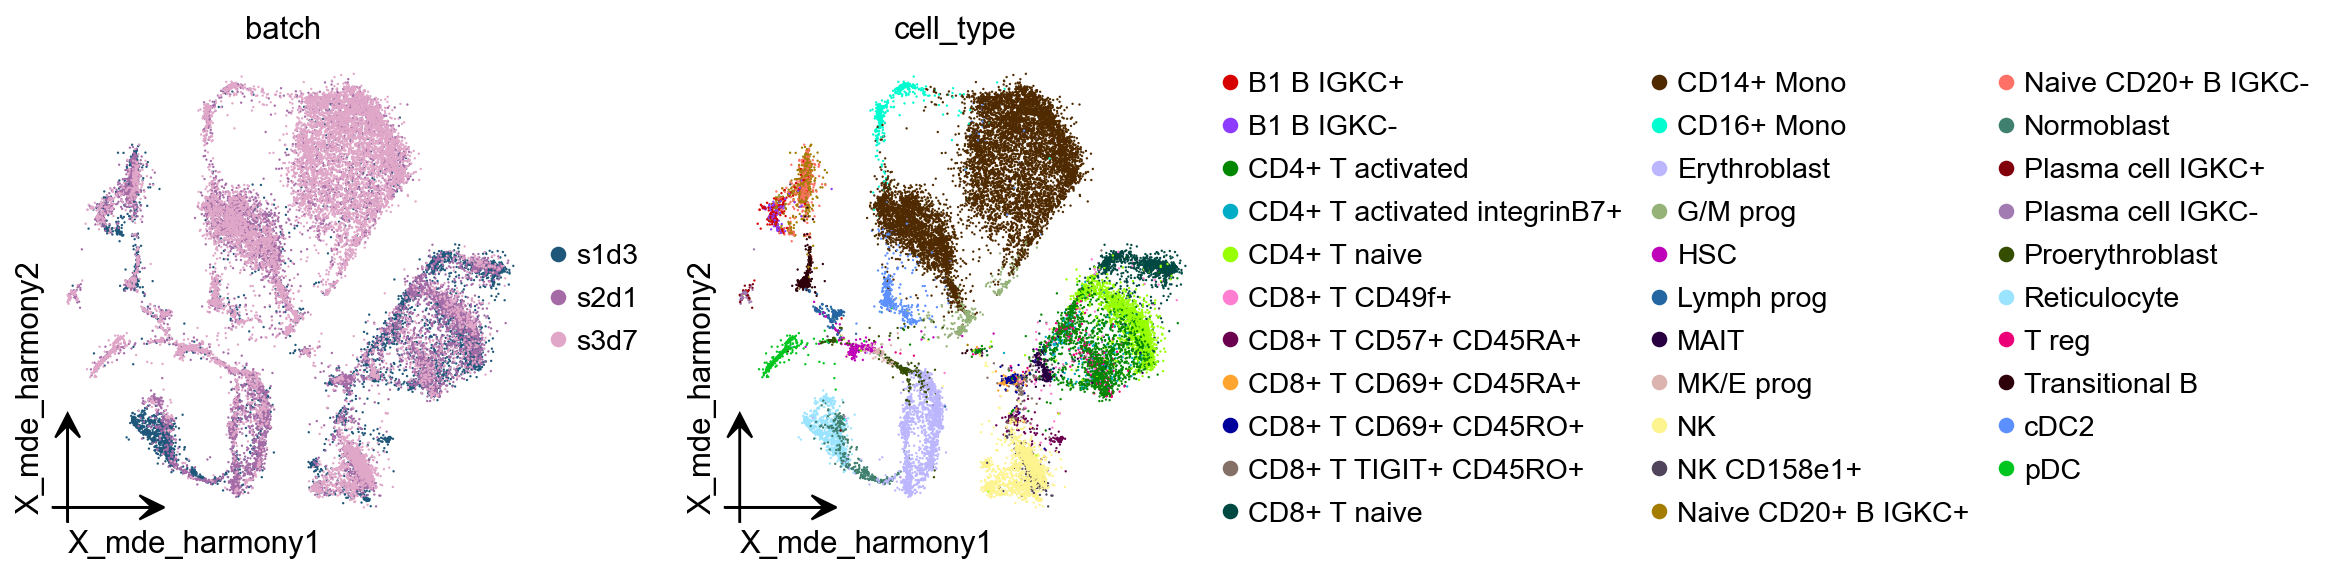

In [15]:
ov.utils.embedding(adata,
                basis='X_mde_harmony',frameon='small',
                color=['batch','cell_type'],show=False)

## Combat

combat is a batch effect correction method that is very widely used in bulk RNA-seq, and it works just as well on single-cell sequencing data.



In [16]:
ov.single.batch_correction(adata,batch_key='batch',methods='combat',n_pcs=50)
adata

...Begin using combat to correct batch effect


Standardizing Data across genes.

Found 3 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data

computing PCA
    with n_comps=50
    finished (0:00:08)


AnnData object with n_obs × n_vars = 26713 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'batch_colors', 'cell_type_colors'
    o

In [17]:
adata.obsm["X_mde_combat"] = ov.utils.mde(adata.obsm["X_combat"])

[<Axes: title={'center': 'batch'}, xlabel='X_mde_combat1', ylabel='X_mde_combat2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_combat1', ylabel='X_mde_combat2'>]

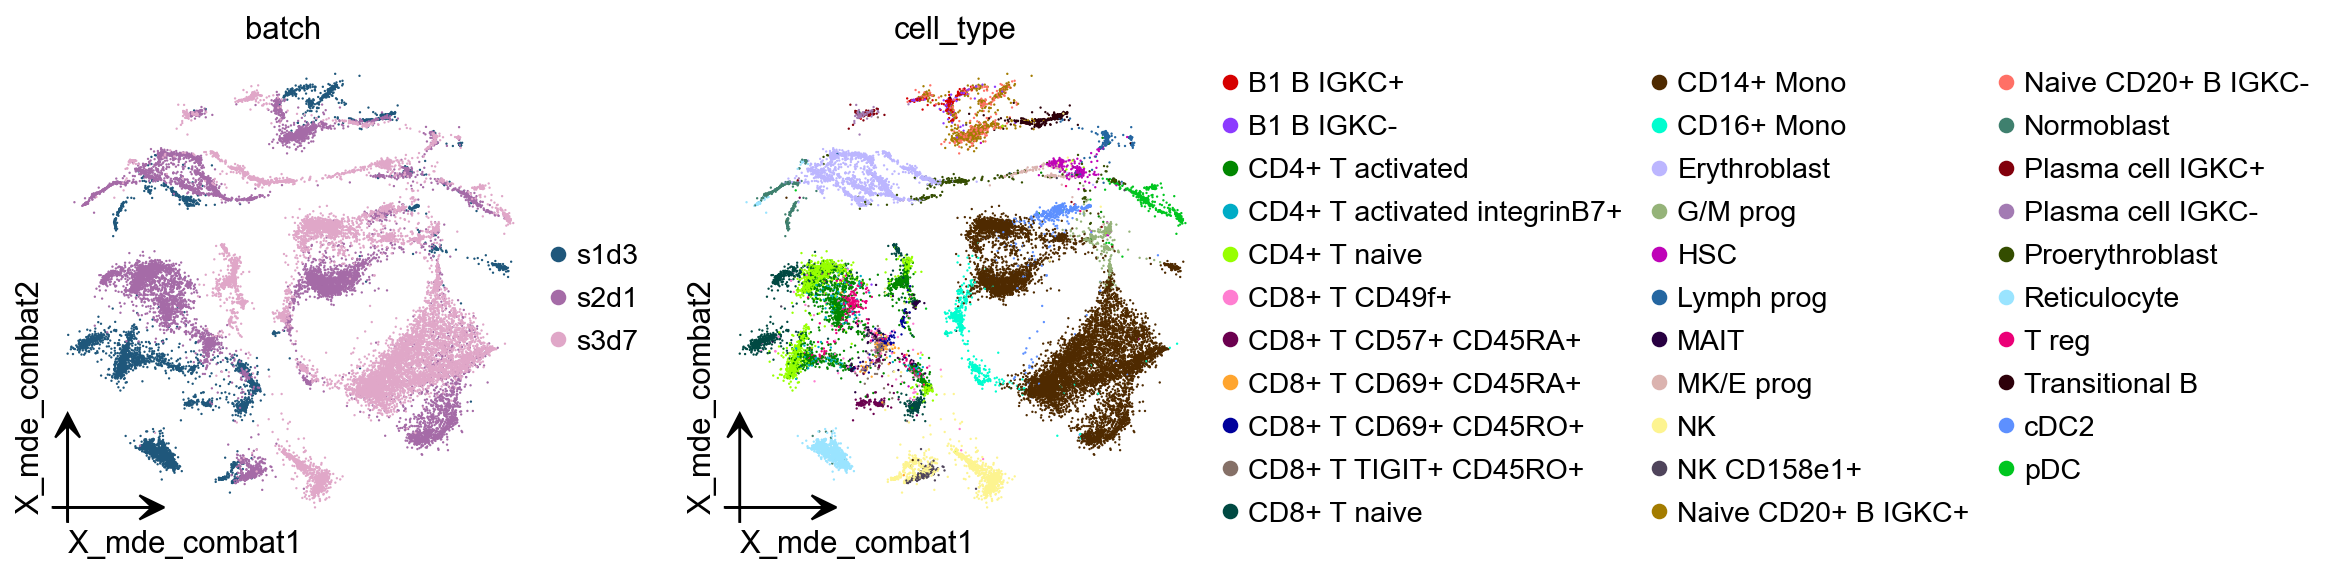

In [18]:
ov.utils.embedding(adata,
                basis='X_mde_combat',frameon='small',
                color=['batch','cell_type'],show=False)

## scanorama

Integration of single-cell RNA sequencing (scRNA-seq) data from multiple experiments, laboratories and technologies can uncover biological insights, but current methods for scRNA-seq data integration are limited by a requirement for datasets to derive from functionally similar cells. We present Scanorama, an algorithm that identifies and merges the shared cell types among all pairs of datasets and accurately integrates heterogeneous collections of scRNA-seq data. 

![scanorama](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41587-019-0113-3/MediaObjects/41587_2019_113_Fig1_HTML.png?as=webp)

In [19]:
ov.single.batch_correction(adata,batch_key='batch', methods='scanorama',n_pcs=50)
adata

...Begin using scanorama to correct batch effect
s1d3
s2d1
s3d7
Found 3000 genes among all datasets


[[0.         0.52430967 0.55751313]
 [0.         0.         0.60914782]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 2)
Processing datasets (0, 1)
(26713, 50)


AnnData object with n_obs × n_vars = 26713 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'batch_colors', 'cell_type_colors'
    o

In [20]:
adata.obsm["X_mde_scanorama"] = ov.utils.mde(adata.obsm["X_scanorama"])

[<Axes: title={'center': 'batch'}, xlabel='X_mde_scanorama1', ylabel='X_mde_scanorama2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_scanorama1', ylabel='X_mde_scanorama2'>]

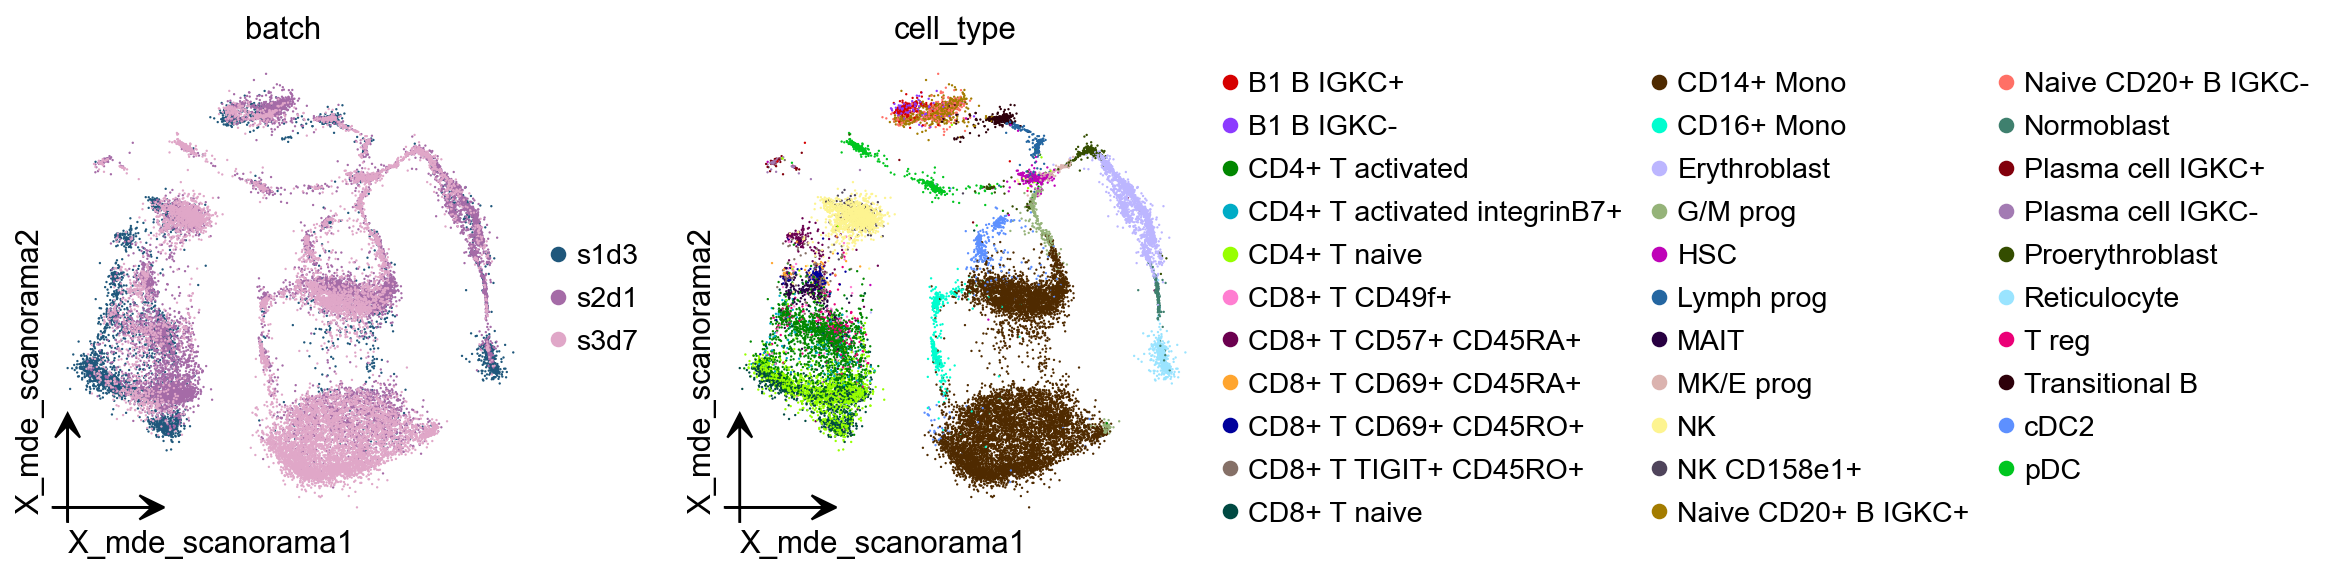

In [21]:
ov.utils.embedding(adata,
                basis='X_mde_scanorama',frameon='small',
                color=['batch','cell_type'],show=False)

## scVI

An important task of single-cell analysis is the integration of several samples, which we can perform with scVI. For integration, scVI treats the data as unlabelled. When our dataset is fully labelled (perhaps in independent studies, or independent analysis pipelines), we can obtain an integration that better preserves biology using scANVI, which incorporates cell type annotation information. Here we demonstrate this functionality with an integrated analysis of cells from the lung atlas integration task from the scIB manuscript. The same pipeline would generally be used to analyze any collection of scRNA-seq datasets.

In [22]:
model=ov.single.batch_correction(adata,batch_key='batch',
                           methods='scVI',n_layers=2, n_latent=30, gene_likelihood="nb")
adata

...Begin using scVI to correct batch effect


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training:   0%|          | 0/299 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=299` reached.


AnnData object with n_obs × n_vars = 26713 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'batch_co

In [23]:
adata.obsm["X_mde_scVI"] = ov.utils.mde(adata.obsm["X_scVI"])

[<Axes: title={'center': 'batch'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>]

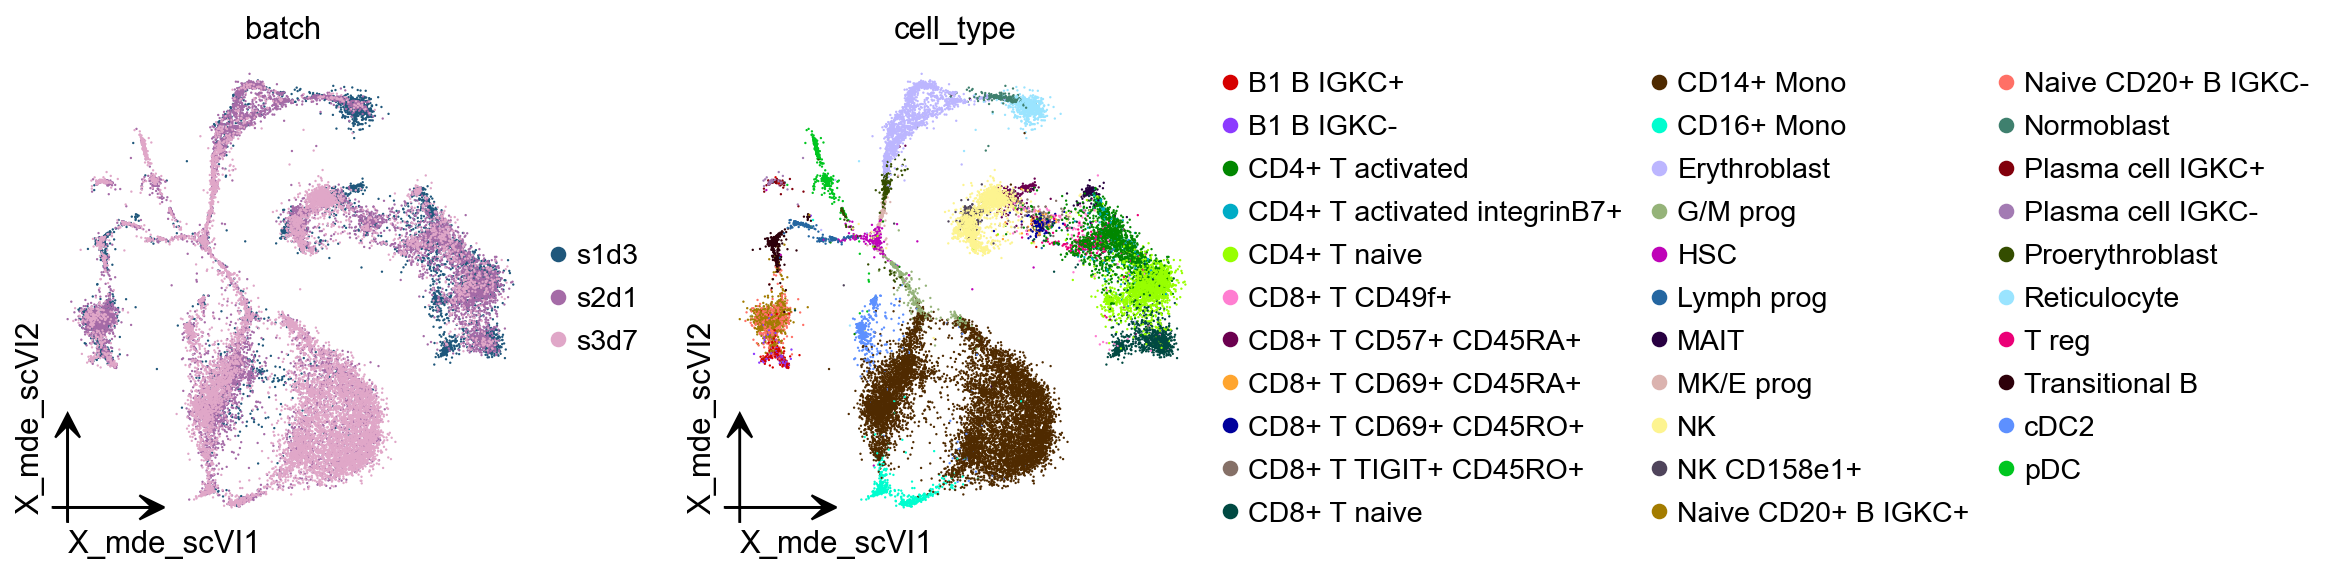

In [24]:
ov.utils.embedding(adata,
                basis='X_mde_scVI',frameon='small',
                color=['batch','cell_type'],show=False)

## CellANOVA

The integration of cells across samples to remove unwanted batch variation plays a critical role in single cell analyses. When the samples are expected to be biologically distinct, it is often unclear how aggressively the cells should be aligned across samples to achieve uniformity. CellANOVA is a Python package for batch integration with signal recovery in single cell data. It builds on existing single cell data integration methods, and uses a pool of control samples to quantify the batch effect and separate meaningful biological variation from unwanted batch variation. When used with an existing integration method, CellAnova allows the recovery of biological signals that are lost during integration.

In omicverse, you only need to prepare the `control_dict`(At least two samples are required!) when you want to try `CellANOVA`. When you're done running it, there are two outputs you need to be aware of:

1. the first one being: `adata.layers['denoised']`, which stores the matrix after the batch effect is removed.
2. The second is `adata.obsm['X_mde_cellANOVA']`, which stores the low-dimensional representation of the cell after removing the batch effect

- Zhang, Z., Mathew, D., Lim, T.L. et al. Recovery of biological signals lost in single-cell batch integration with CellANOVA. Nat Biotechnol (2024). https://doi.org/10.1038/s41587-024-02463-1

In [25]:
## construct control pool
control_dict = {'pool1': ['s1d3','s2d1'],}

ov.single.batch_correction(adata,batch_key='batch',n_pcs=50,
                           methods='CellANOVA',control_dict=control_dict)
adata

...Begin using CellANOVA to correct batch effect
computing PCA
    with n_comps=70


    finished (0:00:12)


2025-08-05 13:43:07,053 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-05 13:43:09,979 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-05 13:43:10,110 - harmonypy - INFO - Iteration 1 of 30
2025-08-05 13:43:15,803 - harmonypy - INFO - Iteration 2 of 30
2025-08-05 13:43:21,585 - harmonypy - INFO - Iteration 3 of 30
2025-08-05 13:43:27,280 - harmonypy - INFO - Iteration 4 of 30
2025-08-05 13:43:33,004 - harmonypy - INFO - Iteration 5 of 30
2025-08-05 13:43:36,938 - harmonypy - INFO - Iteration 6 of 30
2025-08-05 13:43:38,791 - harmonypy - INFO - Converged after 6 iterations
100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


computing PCA
    with n_comps=50
    finished (0:00:32)


AnnData object with n_obs × n_vars = 26713 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features', 'highly_variable'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eige

In [26]:
adata.obsm["X_mde_cellANOVA"] = ov.utils.mde(adata.obsm["X_cellanova"])

[<Axes: title={'center': 'batch'}, xlabel='X_mde_cellANOVA1', ylabel='X_mde_cellANOVA2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_cellANOVA1', ylabel='X_mde_cellANOVA2'>]

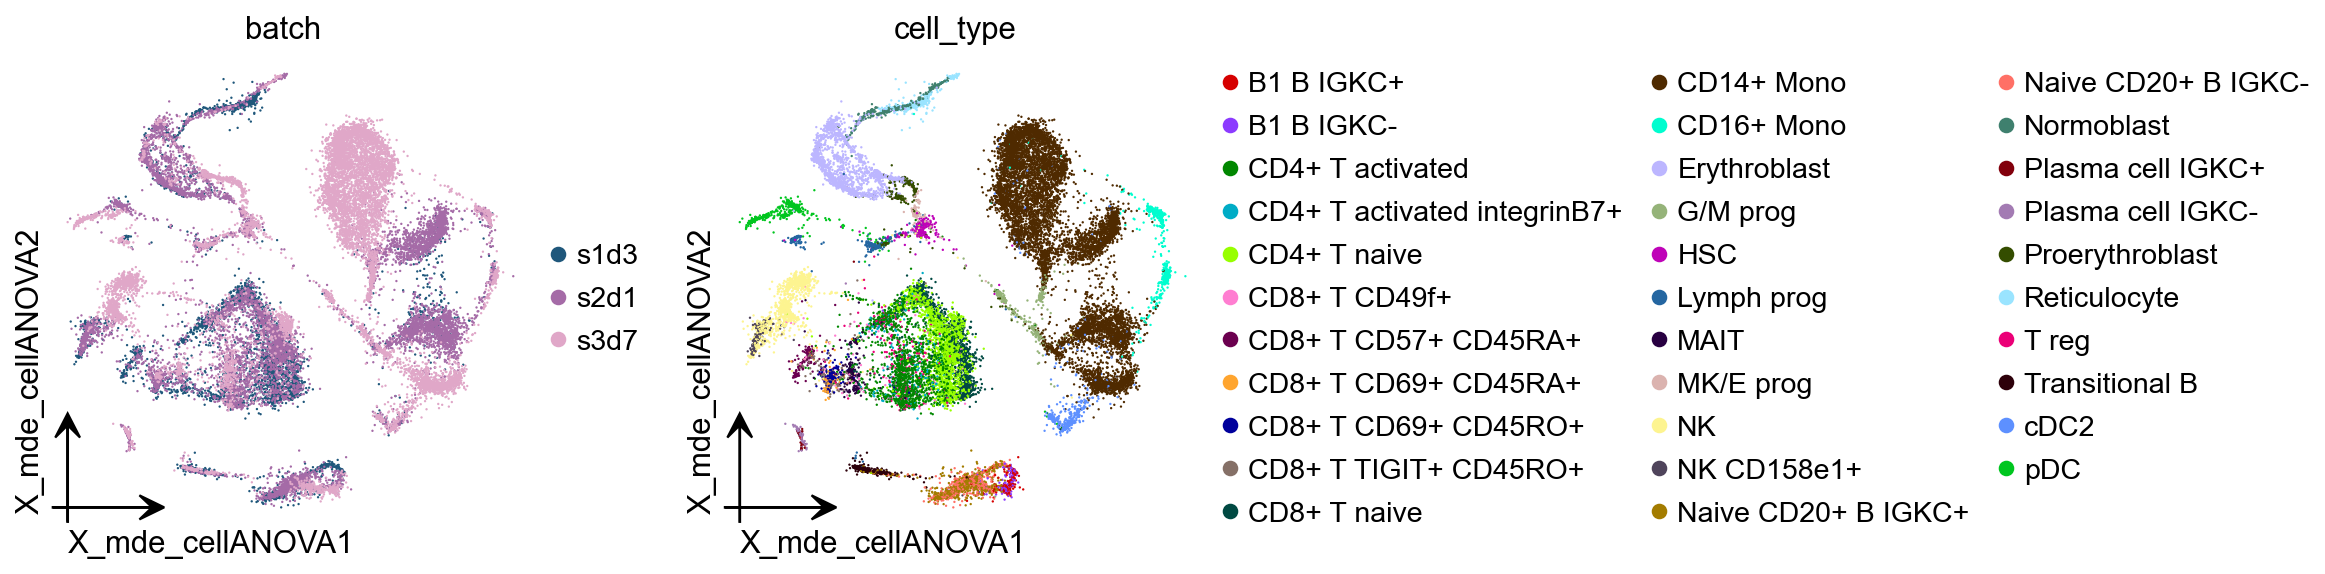

In [27]:
ov.pl.embedding(adata,
                basis='X_mde_cellANOVA',frameon='small',
                color=['batch','cell_type'],show=False)

## MIRA+CODAL

Topic modeling of batched single-cell data is challenging because these models cannot typically distinguish between biological and technical effects of the assay. CODAL (COvariate Disentangling Augmented Loss) uses a novel mutual information regularization technique to explicitly disentangle these two sources of variation.

In [31]:
adata

AnnData object with n_obs × n_vars = 26713 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features', 'highly_variable'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eige

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable_features


mira have been install version: 2.1.1


Gathering dataset statistics:   0%|          | 0/26713 [00:00<?, ?it/s]

Learning rate range test:   0%|          | 0/98 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Set learning rates to: (0.0033069246924335265, 0.30453636059454753)


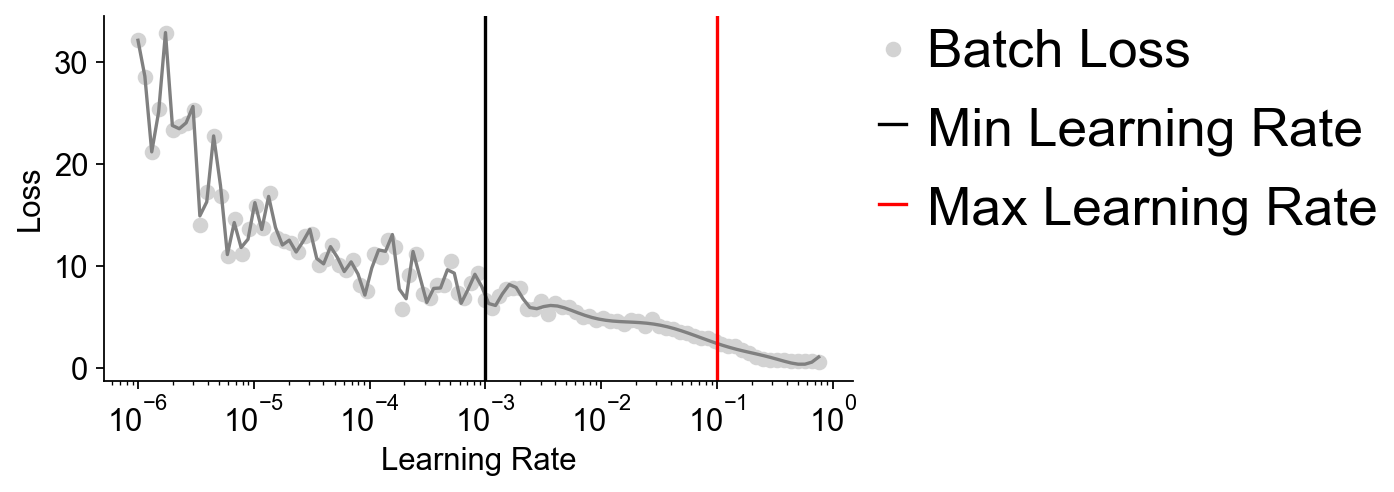

In [32]:
LDA_obj=ov.utils.LDA_topic(adata,feature_type='expression',
                  highly_variable_key='highly_variable_features',
                 layers='counts',batch_key='batch',learning_rate=1e-3)

In [33]:
LDA_obj.plot_topic_contributions(5)

Gathering dataset statistics:   0%|          | 0/26713 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]

Gathering dataset statistics:   0%|          | 0/26713 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]

Gathering dataset statistics:   0%|          | 0/26713 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]

ValueError: Could not train the Gradient-based tuner.
• This can happen if the maximum learning rate was initially set too high. Please ensure you have run the learning rate range test and set reasonable learning rate boundaries.
• This could also happen because there are outliers in the dataset in terms of the number of reads in a cell. Make sure to remove outlier cells from the dataset, especially those with too many counts.
• For accessibility (ATAC-seq) models, this can occur when modeling too many features (>150K). Removing extremenly rarely-accessible peaks to reduce the feature space will help.

If none of the above work, the standard Bayesian Tuning approach is not affected by numberical stability issues like the gradient-based estimator, so try that next.The issues affecting numerical stability of the Dirichlet Process model are being investigated.

In [ ]:
LDA_obj.predicted(15)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable_features


running LDA topic predicted


Gathering dataset statistics:   0%|          | 0/26717 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Moving model to device: cpu


Predicting latent vars:   0%|          | 0/105 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


finished: found 15 clusters and added
    'LDA_cluster', the cluster labels (adata.obs, categorical)


In [ ]:
adata.obsm["X_mde_mira_topic"] = ov.utils.mde(adata.obsm["X_topic_compositions"])
adata.obsm["X_mde_mira_feature"] = ov.utils.mde(adata.obsm["X_umap_features"])

... storing 'LDA_cluster' as categorical


[<Axes: title={'center': 'batch'}, xlabel='X_mde_mira_topic1', ylabel='X_mde_mira_topic2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_mira_topic1', ylabel='X_mde_mira_topic2'>]

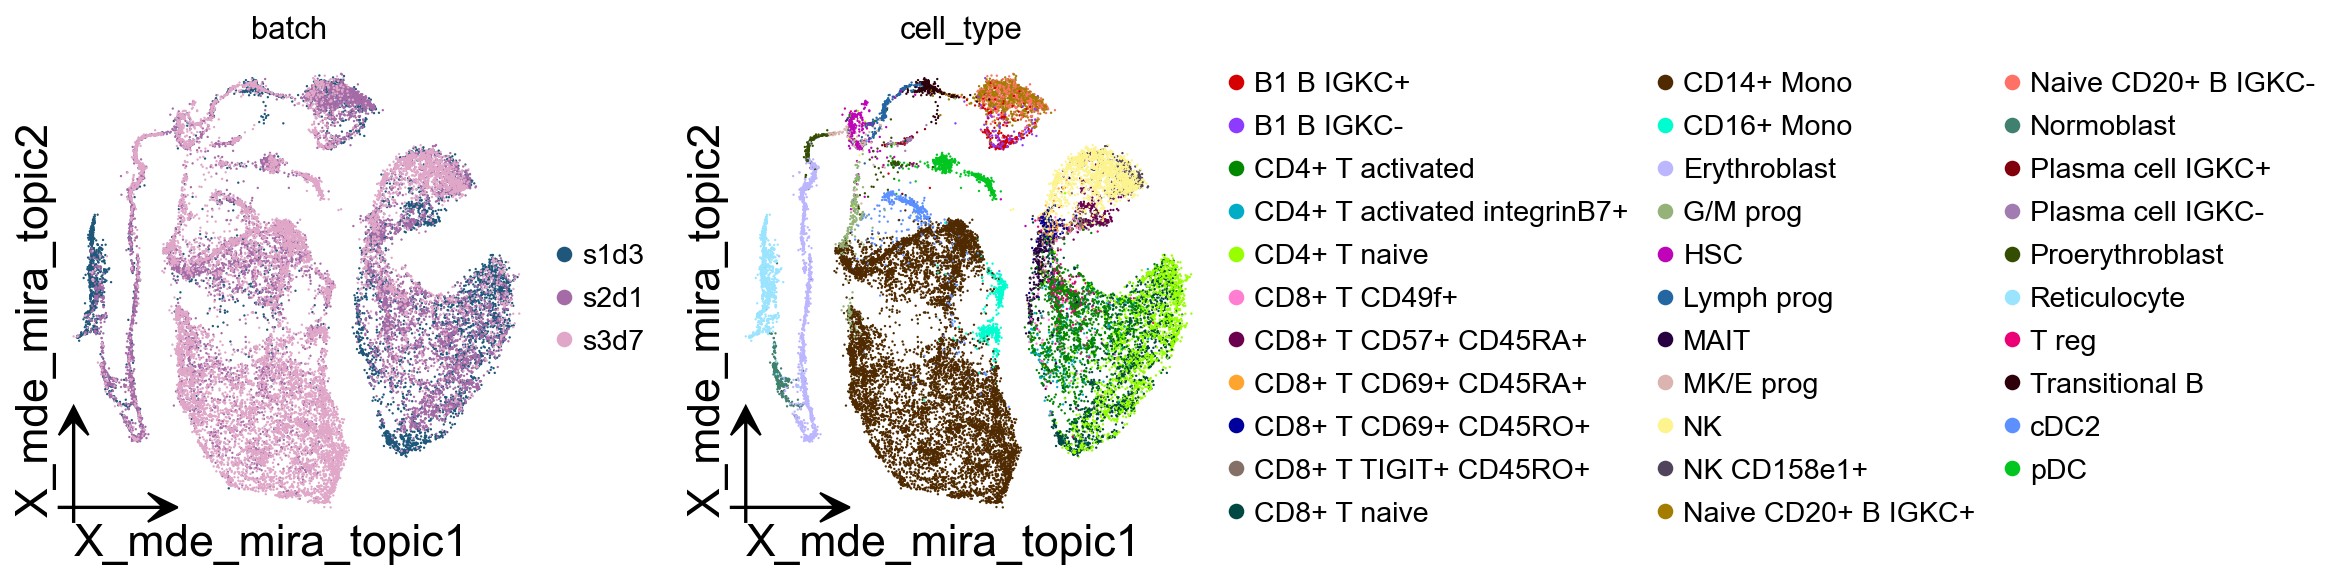

In [ ]:
ov.utils.embedding(adata,
                basis='X_mde_mira_topic',frameon='small',
                color=['batch','cell_type'],show=False)

[<Axes: title={'center': 'batch'}, xlabel='X_mde_mira_feature1', ylabel='X_mde_mira_feature2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_mira_feature1', ylabel='X_mde_mira_feature2'>]

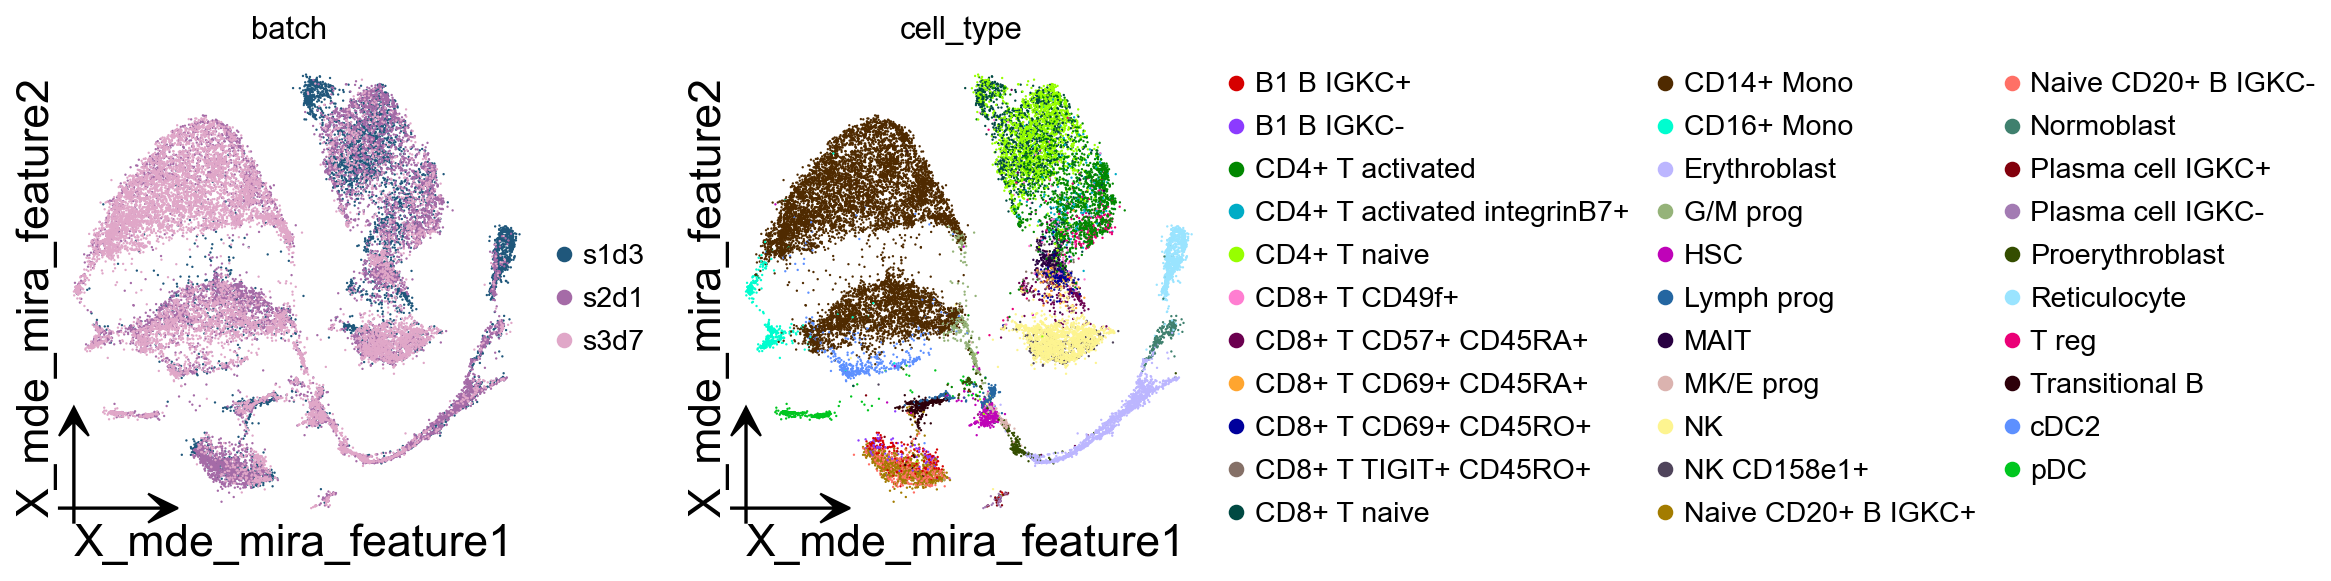

In [ ]:
ov.utils.embedding(adata,
                basis='X_mde_mira_feature',frameon='small',
                color=['batch','cell_type'],show=False)

## Benchmarking test

The methods demonstrated here are selected based on results from benchmarking experiments including the single-cell integration benchmarking project [Luecken et al., 2021]. This project also produced a software package called [scib](https://www.github.com/theislab/scib) that can be used to run a range of integration methods as well as the metrics that were used for evaluation. In this section, we show how to use this package to evaluate the quality of an integration.

In [ ]:
adata.write_h5ad('neurips2021_batch_all.h5ad',compression='gzip')

In [ ]:
adata=sc.read('neurips2021_batch_all.h5ad')

In [ ]:
adata.obsm['X_pca']=adata.obsm['scaled|original|X_pca'].copy()
adata.obsm['X_mira_topic']=adata.obsm['X_topic_compositions'].copy()
adata.obsm['X_mira_feature']=adata.obsm['X_umap_features'].copy()

In [ ]:
from scib_metrics.benchmark import Benchmarker
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", "X_combat", "X_harmony",'X_cellanova',
                         'X_scanorama','X_mira_topic','X_mira_feature','X_scVI',],
    n_jobs=8,
)
bm.benchmark()

computing PCA
    with n_comps=50
    finished (0:00:09)


Embeddings:   0%|          | 0/8 [00:00<?, ?it/s]INFO:root:isolated labels: no more than 1 batches per label
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


INFO     NK CD158e1+ consists of a single batch or is too small. Skip.                                             


Embeddings:  12%|█▎        | 1/8 [01:34<10:58, 94.04s/it]INFO:root:isolated labels: no more than 1 batches per label


INFO     NK CD158e1+ consists of a single batch or is too small. Skip.                                             


Embeddings:  25%|██▌       | 2/8 [02:09<05:57, 59.55s/it]INFO:root:isolated labels: no more than 1 batches per label


INFO     NK CD158e1+ consists of a single batch or is too small. Skip.                                             


Embeddings:  38%|███▊      | 3/8 [02:42<03:56, 47.26s/it]INFO:root:isolated labels: no more than 1 batches per label


INFO     NK CD158e1+ consists of a single batch or is too small. Skip.                                             


Embeddings:  50%|█████     | 4/8 [03:13<02:43, 40.94s/it]INFO:root:isolated labels: no more than 1 batches per label


INFO     NK CD158e1+ consists of a single batch or is too small. Skip.                                             


Embeddings:  62%|██████▎   | 5/8 [03:42<01:50, 36.76s/it]INFO:root:isolated labels: no more than 1 batches per label


INFO     NK CD158e1+ consists of a single batch or is too small. Skip.                                             


Embeddings:  75%|███████▌  | 6/8 [04:22<01:15, 37.70s/it]INFO:root:isolated labels: no more than 1 batches per label


INFO     NK CD158e1+ consists of a single batch or is too small. Skip.                                             


Embeddings:  88%|████████▊ | 7/8 [04:56<00:36, 36.42s/it]INFO:root:isolated labels: no more than 1 batches per label


INFO     NK CD158e1+ consists of a single batch or is too small. Skip.                                             


Embeddings: 100%|██████████| 8/8 [05:28<00:00, 41.10s/it]


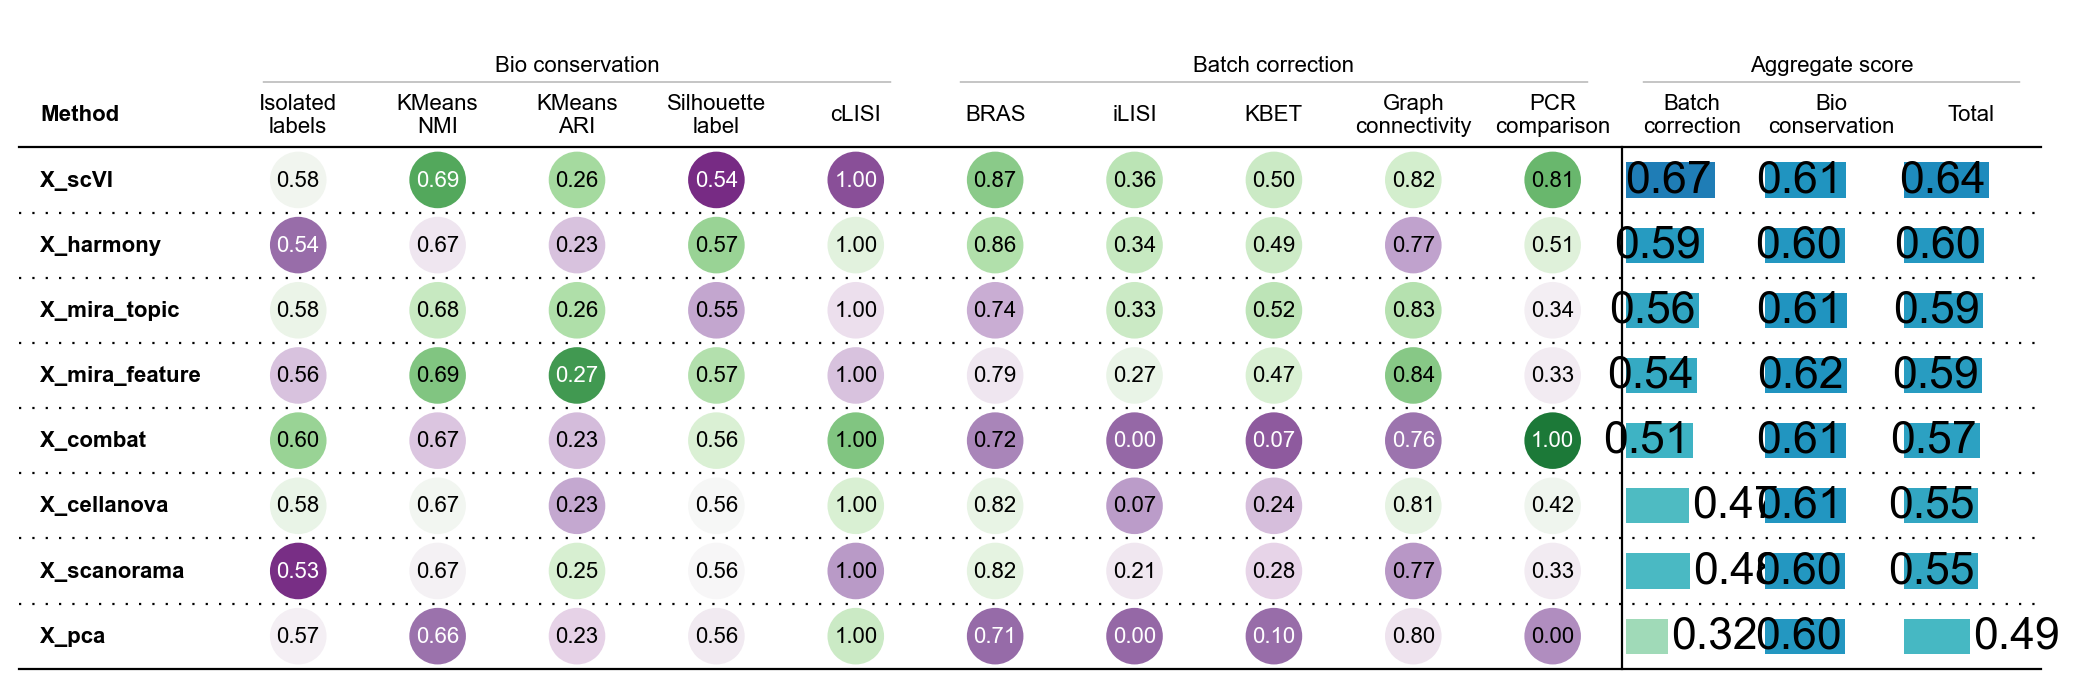

In [ ]:
bm.plot_results_table(min_max_scale=False)

We can find that harmony removes the batch effect the best of the three methods that do not use the GPU, scVI is method to remove batch effect using GPU.